In [1]:
episodefile = open("../data/EpisodeList.txt","r")
episodeList = []

for line in episodefile:
    episodeList.append(line.strip().lower().replace(",",""))

SeasonList = [10,10,10,10,10,10,7,6]
episodeTuple = []
ekstranumb = 0
for numb in range(len(SeasonList)):
    for i in range(SeasonList[numb]):
        episodeTuple.append((numb+1, episodeList[i+ekstranumb]))
    ekstranumb += SeasonList[numb]

In [104]:
#import lyricsgenius
#genius = lyricsgenius.Genius("Apa5yYNZVRkIvn1izsQWN5l957pSR9jiG24s8ExAPKE9FHY9gdq4W8P7GPavWn1n")
#artist = genius.search_artist("Game of Thrones")
#artist.save_lyrics()

In [2]:
import json
jFile = open("Lyrics_GameofThrones.json", "r")
j = json.load(jFile)

#Ignore this
#Dont even worry about it
#Just a simple Dict comprehension, no need to analyze it
LyricsListDict = {j["songs"][w]["title_with_featured"].lower().replace(",",""):j["songs"][w]["lyrics"].encode("UTF-8").decode("UTF-8") 
                    for w in range(len(j["songs"])) 
                    if j["songs"][w]["title_with_featured"].lower().replace(",","") in episodeList}



In [3]:
SeasonDict = dict()
#SeasonDict format
# {Title:{Season:SeasonNumber,Script:ScriptText}}
season1counter = 0
for season, title in episodeTuple:
    if season != 1:
        SeasonDict[title] = {"season": int(season),"script":LyricsListDict[title]}
    else:
        season1counter += 1
        script = ""
        path = f"../data/GOT_Season_1_Formatted/Episode{season1counter}.txt"
        #print(path)
        with open(path,'r') as file:
            script = " ".join(file.readlines())
            #print((script))
        SeasonDict[title] = {"season": int(season),"script":script}
        print(season1counter)


SeasonDict["winter is coming"]

1
2
3
4
5
6
7
8
9
10


{'season': 1,
 'script': 'EXT. Unknown\n \n WAYMAR ROYCE: What d\'you expect? They\'re savages. One lot steals a goat from another lot and before you know it, they\'re ripping each other to pieces.\n \n WILL: I\'ve never seen wildlings do a thing like this. I\'ve never seen a thing like this, not ever in my life.\n \n WAYMAR ROYCE: How close did you get?\n \n WILL: Close as any man would.\n \n GARED: We should head back to the wall.\n \n ROYCE: Do the dead frighten you?\n \n GARED: Our orders were to track the wildlings. We tracked them. They won\'t trouble us no more.\n \n ROYCE: You don\'t think he\'ll ask us how they died? Get back on your horse.\n \n [GARED grumbles.]\n \n WILL: Whatever did it to them could do it to us. They even killed the children.\n \n ROYCE: It\'s a good thing we\'re not children. You want to run away south, run away. Of course, they will behead you as a deserter ... If I don\'t catch you first. Get back on your horse. I won\'t say it again.\n \n [WILL glares,

In [4]:

def sceneNameChecker(screenLine:str, i:int, lineSplit:str, sceneList:list, saveResult: bool):
    
    sceneName = None
    
    if lineSplit[0].upper() == "CUT TO":
        sceneName = lineSplit[1].strip()

    elif screenLine.strip().startswith('EXT'):
        sceneName = screenLine.strip()[4:].strip()

    elif screenLine.strip().startswith('INT'):
        sceneName = screenLine.strip()[4:].strip()

    elif 'EXT.' in screenLine.strip():
        #print(screenLine)
        sceneName = screenLine.split("EXT.")[1].strip()
        #print(sceneName)
    elif 'EXT:' in screenLine.strip():
        #print(screenLine)
        sceneName = screenLine.split("EXT:")[1].strip()
        #print(sceneName)
    elif 'INT:' in screenLine.strip():
        #print(screenLine)
        sceneName = screenLine.split("INT:")[1].strip()
        #print(sceneName)
    elif 'INT.' in screenLine.strip():
        #print(screenLine)
        sceneName = screenLine.split("INT.")[1].strip()
        #print(sceneName)
    elif screenLine.strip().startswith("--------"):
        sceneName = "Unnamed Scene"

    elif screenLine.upper().strip().startswith("CUT TO"):
        sceneName = screenLine.strip()[7:].strip()

    elif "SCENE SHIFTS" in screenLine.upper():
        sceneName = screenLine.upper().split("SCENE SHIFTS")[1].split(".")[0].replace(",","").strip()
    elif "SCENE CHANGES" in screenLine.upper():
        sceneName = screenLine.upper().split("SCENE CHANGES")[1].split(".")[0].replace(",","").strip()
    elif "NEWSCENE" in screenLine.upper():
        sceneName = "New Scene"
    elif i == 0:
        sceneName = "Opening Scene"
    
    #Giving the sceneName an extra number if the sceneName occurs multiple times
    
    
    if sceneName is not None:
        if str(sceneName) in sceneList:
            try:
                sceneNameOld = sceneName
                sceneName = str(sceneName) + "_" + str(sceneList.count(sceneName))
                if saveResult is False:
                    return True, True, True
                sceneList.append(str(sceneNameOld))
                
            except TypeError as error:
                print("Error:", sceneName)
            
        else:
            if saveResult is False:
                return True, "True", "True"
            sceneList.append(str(sceneName))
        
        return True, str(sceneName), sceneList
       
        
    return False, False, False


def createDataframefromDict(screenplayDict:dict):
 
    dfcolumns = ['Person','SeasonNr','EpisodeID','EpisodeTitle','Scene','ScreenLine']


    sceneList = []
    allLines = []
    episodeID = 0
    

    for title in screenplayDict:

        episodeTitle = title
        episodeID += 1
        seasonNr = int(screenplayDict[title]['season'])
        
        sceneName = None

        screenLines = screenplayDict[title]['script'].replace("\n\n\n", "NEWSCENE\n")
        if seasonNr == 1 and episodeID != 8:
            screenLines = screenLines.split("\n \n")
        else:
            screenLines = screenLines.split("\n")
        if "" in screenLines:
            screenLines.remove("")
        
        for i in range(len(screenLines)):
            
            lines = screenLines[i].split("\n")
            
            for line in lines:
        
                lineSplit = line.strip().split(":")
                

                if len(lineSplit) > 1 or sceneNameChecker(line,i,lineSplit,sceneList, False)[0] is True:

                    if sceneNameChecker(line,i,lineSplit,sceneList, False)[0] is True:
                        _, sceneName, sceneList = sceneNameChecker(line,i,lineSplit, sceneList, True)
                                    

                    elif len(lineSplit) >= 2:
                        if sceneName is None:
                            _, sceneName, sceneList = sceneNameChecker(line,0,lineSplit, sceneList, True)

                        person = str(lineSplit[0].split("(")[0].strip()).upper()
                        screenLine = str(lineSplit[1]).strip()
                        
                        newEntry = [person, seasonNr, episodeID, episodeTitle, sceneName, screenLine]
                        
                        allLines.append(newEntry)
                        
                    
                else:
                    if ("EXT.") in line:
                        print(i,episodeID, "Error", lineSplit)
                    if "SCENE SHIFTS" in str(line).upper() or "SCENE CHANGES" in str(line).upper() and len(line[0].strip()) > 0:
                        
                        _, sceneName, sceneList = sceneNameChecker(line,0,lineSplit, sceneList, True)
                        #print(sceneName)
            


    df = pd.DataFrame(allLines,columns=dfcolumns)
    return df

In [5]:
import numpy as np
def format_name(person_list: list, verbose = False) -> list:
    metadata = pd.read_csv('../data/characher_metadata2.csv')
    c2n = pd.read_csv('../data/characterToName.csv', header = None)

    # 'One comprehenssion to rule them all, One comprehenssion to find them, One comprehenssion to bring them all and in the darkness bind them.
    alias2name = {alias.strip().lower():name.strip().lower() for alias, name in zip(c2n.iloc[:,0],c2n.iloc[:,1]) if alias is not np.nan and name is not np.nan}
    metadata_ls = [person.lower() for person in metadata.iloc[:,0]]
    metadata_uniq = set(metadata_ls)

    
    valid_persons = []
    for person in person_list:
        person = person.lower()
        person = person.replace('king', '')
        person = person.replace('young', '')
        person = person.replace('ser', '')
        person = person.replace('lord', '')
        person = person.replace('maester', '')
        person = person.replace('grand maester', '')
        person = person.strip()
    
        if person in metadata_uniq:
            valid_persons.append(person)
    #ic(valid_persons)
            
        if person not in metadata_uniq:
            if person in alias2name:
                valid_persons.append(alias2name[person])
                if verbose and person != alias2name[person]:
                    print(f'{person} -> {alias2name[person]}')
                    pass
            else:
                valid_persons.append(np.nan)
                if verbose:
                    print(f'{person} -> nan')
    
    
    
    return valid_persons

In [7]:
import pandas as pd

df = createDataframefromDict(SeasonDict)
#print(df)
df["Person"] = format_name(df.Person, verbose = False)

pd.DataFrame.dropna(df,axis=0, how = 'any', inplace = True)
df

,Person,SeasonNr,EpisodeID,EpisodeTitle,Scene,ScreenLine
0,waymar royce,1,1,winter is coming,Unknown,What d'you expect? They're savages. One lot st...
1,will,1,1,winter is coming,Unknown,I've never seen wildlings do a thing like this...
2,waymar royce,1,1,winter is coming,Unknown,How close did you get?
3,will,1,1,winter is coming,Unknown,Close as any man would.
4,gared,1,1,winter is coming,Unknown,We should head back to the wall.
...,...,...,...,...,...,...
24997,sam,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,Uh... the Archmaester is less than enthusiasti...
24998,bronn,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,"Well, I imagine he isn't using them properly."
24999,brienne of tarth,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,I think we can all agree that ships take prece...
25000,bronn,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,I think that's a very presumptuous statement.


In [8]:
sorted(set(df[df["SeasonNr"] == 1]["Scene"]))
((df[df["SeasonNr"] == 1]))

,Person,SeasonNr,EpisodeID,EpisodeTitle,Scene,ScreenLine
0,waymar royce,1,1,winter is coming,Unknown,What d'you expect? They're savages. One lot st...
1,will,1,1,winter is coming,Unknown,I've never seen wildlings do a thing like this...
2,waymar royce,1,1,winter is coming,Unknown,How close did you get?
3,will,1,1,winter is coming,Unknown,Close as any man would.
4,gared,1,1,winter is coming,Unknown,We should head back to the wall.
...,...,...,...,...,...,...
3396,daenerys targaryen,1,10,fire and blood,Across the Narrow Sea_3,ls that what you fear? (kisses Jorah on the ch...
3397,daenerys targaryen,1,10,fire and blood,Across the Narrow Sea_3,"Ser Jorah, bind this woman to the pyre. You sw..."
3398,mirri maz duur,1,10,fire and blood,Across the Narrow Sea_3,You will not hear me scream.
3399,daenerys targaryen,1,10,fire and blood,Across the Narrow Sea_3,I will. But it is not your screams I want. Onl...


In [29]:
df.to_csv('../data/scene_data.csv')
df["Scene"]

0                        Unknown
1                        Unknown
2                        Unknown
3                        Unknown
4                        Unknown
                  ...           
24997    SMALL COUNCIL CHAMBER_4
24998    SMALL COUNCIL CHAMBER_4
24999    SMALL COUNCIL CHAMBER_4
25000    SMALL COUNCIL CHAMBER_4
25001    SMALL COUNCIL CHAMBER_4
Name: Scene, Length: 23634, dtype: object

In [10]:
import json
import ast
import pandas as pd
D = pd.read_csv('../data/characher_metadata2.csv')
#Creating house dict
houseDict = dict()
for name, houses, affiliation in zip(D.iloc[:,0],D.iloc[:,1],D.iloc[:,2]):
    houseDict[name.lower()] = {}
    if houses.strip('[]') != '':   
        houses = ast.literal_eval(houses)
        houselist = []
        for house in houses:
            houselist.append(house.split("/")[0])
            
        houseDict[name.lower()]["house"] = houselist
    if affiliation.strip('[]') != '':  
        affiliation = ast.literal_eval(affiliation)
        affiliations = []
        for aff in affiliation:
            affiliations.append(aff.split("/")[0])
        
        houseDict[name.lower()]["affiliations"] = affiliations
print(houseDict)
count = 0
for name, house in houseDict.items():
    if len(house) > 2:
        print(name, house)
        count+= 1


{'mag mar tun doh weg': {'affiliations': ['Mance Rayder']}, 'ro:baelor': {}, 'es:libro del desconocido': {}, 'bobby asghar': {}, "the queen's justice": {}, 'fionn kernan': {}, 'elie haddad': {}, "game of thrones musical themes and motifs#tyrion's theme": {}, 'nagga': {}, 'pl:smok i wilk': {}, 'rea separovic': {}, 'alannys greyjoy': {'house': ['House Harlaw', 'House Greyjoy']}, 'stephen dillane': {}, 'slave (breaker of chains)': {'affiliations': ['Great Masters']}, 'file:blood of my blood 21.jpg': {}, 'janos slynt': {'house': ['House Slynt'], 'affiliations': ["City Watch of King's Landing", "Night's Watch"]}, 'viserys i targaryen': {'house': ['House Targaryen']}, 'roose bolton#in the books': {}, 'wuese houston-jibo': {}, 'house of the dragon: season 1': {}, 'dermot ward': {}, 'bloodrider': {}, 'es:besado por el fuego': {}, 'common tongue#regional accents': {}, 'kate anthony': {}, 'sophia smith': {}, 'winterfell (episode)': {}, 'aerion targaryen': {'house': ['House Targaryen']}, 'fr:bata

In [37]:
def getAffiliationsToDF(persons, houseDict):
    houseList = []
    affiliationList = []
    for person in persons:
        try:
            houseList.append(", ".join(houseDict[person]["house"]).strip())
        except KeyError as error:
            print(error)
            houseList.append("None")
        try:
            affiliationList.append(", ".join(houseDict[person]["affiliations"]).strip())
        except KeyError as error:
            print(error)
            affiliationList.append("None")
    return houseList, affiliationList
df["House"], df["Affiliations"] = getAffiliationsToDF(df["Person"], houseDict)
df.to_csv('../data/scene_data.csv')
df



'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'house'
'house'
'house'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'house'
'affiliations'
'house'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'affiliations'
'house'
'affiliations'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'house'
'affiliations'
'house'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'affiliations'
'house'
'affiliations'
'affiliati

,Person,SeasonNr,EpisodeID,EpisodeTitle,Scene,ScreenLine,House,Affiliations
0,waymar royce,1,1,winter is coming,Unknown,What d'you expect? They're savages. One lot st...,House Royce,Night's Watch
1,will,1,1,winter is coming,Unknown,I've never seen wildlings do a thing like this...,None,Night's Watch
2,waymar royce,1,1,winter is coming,Unknown,How close did you get?,House Royce,Night's Watch
3,will,1,1,winter is coming,Unknown,Close as any man would.,None,Night's Watch
4,gared,1,1,winter is coming,Unknown,We should head back to the wall.,None,Night's Watch
...,...,...,...,...,...,...,...,...
24997,sam,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,Uh... the Archmaester is less than enthusiasti...,None,None
24998,bronn,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,"Well, I imagine he isn't using them properly.",Bronn's house,"Catelyn Stark, House Lannister, City Watch of ..."
24999,brienne of tarth,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,I think we can all agree that ships take prece...,House Tarth,"House Baratheon, Kingsguard, Renly Baratheon, ..."
25000,bronn,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,I think that's a very presumptuous statement.,Bronn's house,"Catelyn Stark, House Lannister, City Watch of ..."


In [11]:
lineDict = dict()

# LineDict -> key: Scene -> key: person -> value: lines
#                        -> value: seasonnr
#                        -> value: EpisodeID
#                        -> value: EpisodeTitle

for scene, person, lines, seasonNr, episodeID, episodeTitle in zip(df.Scene, df.Person, df.ScreenLine, df.SeasonNr, df.EpisodeID, df.EpisodeTitle):
    if scene not in lineDict:
        lineDict[scene] = {}
  
    if person not in lineDict[scene]:
        lineDict[scene][person] = {}
        lineDict[scene][person]["SeasonNr"] = seasonNr
        lineDict[scene][person]["EpisodeID"] = episodeID
        lineDict[scene][person]["EpisodeTitle"] = episodeTitle
        
    if "lines" not in lineDict[scene][person]: 
        lineDict[scene][person]["lines"] = []
    

    lineDict[scene][person]["lines"].append(lines)

personLineDict = dict()

for scene, person, lines, seasonNr, episodeID, episodeTitle in zip(df.Scene, df.Person, df.ScreenLine, df.SeasonNr, df.EpisodeID, df.EpisodeTitle):
    if person not in personLineDict:
        personLineDict[person] = {}
    
    connectedPersons = [cp for cp in (lineDict[scene]) if cp != person]


    for otherPerson in connectedPersons:

        if otherPerson not in personLineDict[person]:
            personLineDict[person][otherPerson] = {}

        if seasonNr not in personLineDict[person][otherPerson]:
            personLineDict[person][otherPerson][seasonNr] = {}
        
        if episodeID not in personLineDict[person][otherPerson][seasonNr]:
            personLineDict[person][otherPerson][seasonNr][episodeID] = {}

        if episodeTitle not in personLineDict[person][otherPerson][seasonNr][episodeID]:
            personLineDict[person][otherPerson][seasonNr][episodeID][episodeTitle] = {}
            
        if scene not in personLineDict[person][otherPerson][seasonNr][episodeID][episodeTitle]:
            personLineDict[person][otherPerson][seasonNr][episodeID][episodeTitle][scene] = lineDict[scene][person]["lines"]
   
    

print("Nr of scenes in dict:", len(lineDict))
print("Nr of persons in personLineDict:", len(personLineDict))
#lineDict["Unnamed Scene"]

Nr of scenes in dict: 1561
Nr of persons in personLineDict: 344


In [27]:
import networkx as nx
import pickle

G = nx.DiGraph()
PersonList = set(list(df.Person))

nodeList = []
for person in PersonList:
    if person in houseDict:
        nodeList.append((person, houseDict[person]))
    else:
        nodeList.append((person))

G.add_nodes_from(nodeList)


#[person][otherPerson][seasonNr][episodeID][episodeTitle][scene]
for person in personLineDict:  
    #print(person)  
    for connectedPersons, lines in personLineDict[person].items():

        G.add_edge(person, connectedPersons, lines = lines)
                

print(len(G.nodes()))
file = open("GOTNetwork.pkl",'wb')
pickle.dump(G,file)
file.close()

344


In [ ]:
#Loading network from pickle
#file = open("GOTNetwork.pkl",'rb')
#G = pickle.load(file)
#print(G.nodes(data = True))
#file.close()

In [15]:
print(G["edmure tully"]["robb stark"]['lines'][3][23]["walk of punishment"])

{'RIVERRUN WAR ROOM, LATER': ['If I may, nephew, I encountered a situation with one of my lieutenants at the Stone Mill which may have some bearing-', 'Robb knows I meant him no disr-', "My blunder sent Tywin's mad scurrying back to Casterly Rock with his tail between his legs. I think King Robb understands we're not gonna win this war if he's the only one winning any battles. No, there's glory enough to go around.", 'I seized an opportunity.', 'The Mountain was garrisoned across the river from it.', 'We took the fight to him. He could not withstand us.', 'We took hostages. Willem Lannister. Martyn Lannister.', 'No.', 'No.', 'But for every man we lost, the Lannisters-', "I'm sorry. I didn't know."]}


In [20]:
G.nodes()["jon snow"]

{'house': ['House Targaryen'],
 'affiliations': ['House Stark', "Night's Watch"]}

In [24]:
G.edges()[('cohollo', 'daenerys targaryen')]

{'lines': {1: {9: {'baelor': {'Across the Narrow Sea': ['(in Dothraki) Blood of my blood']}}}}}

In [25]:
d = dict(G.degree)
pos = nx.kamada_kawai_layout(G)

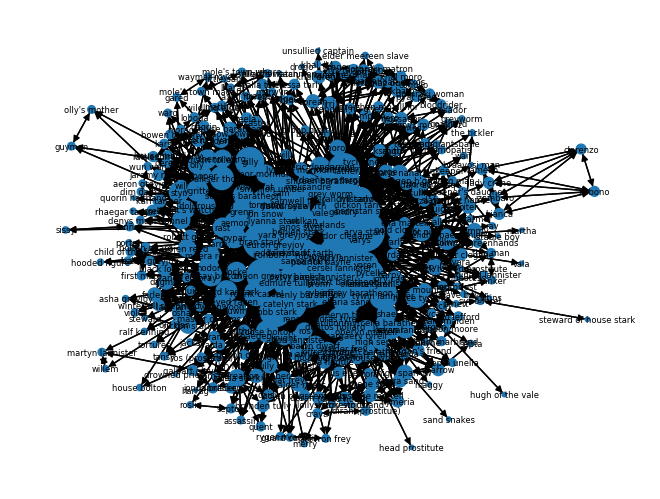

In [26]:
nx.draw(G, pos = pos, node_size=[v * 5 for v in d.values()], with_labels = True, font_size = 6)

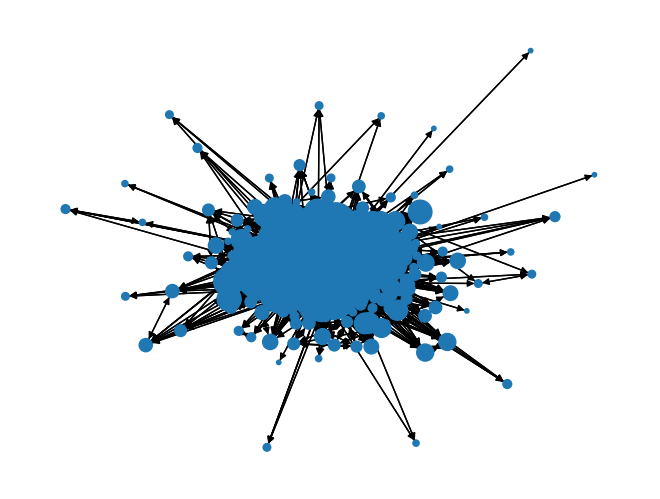

In [115]:
nx.draw(G, pos = pos, node_size=[v * 5 for v in d.values()])